In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Fri Jan 12 17:20:21 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-6/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 37696
-rw-rw-r-- 1 scpark scpark   217028  1월 12 17:20 events.out.tfevents.1705047498.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 17:18 save_0
-rw-rw-r-- 1 scpark scpark   357476  1월 12 17:18 events.out.tfevents.1705047294.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


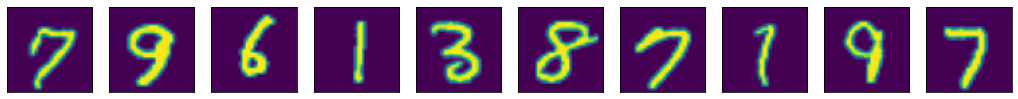

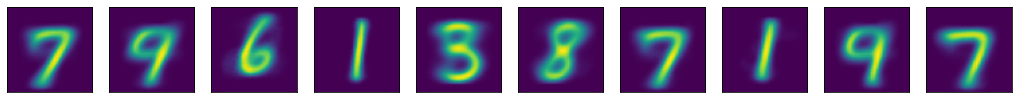

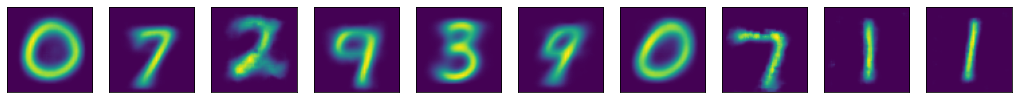

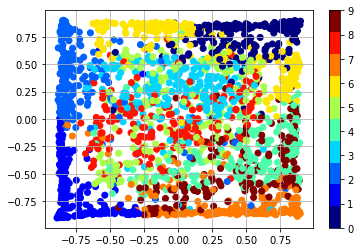

123001
lse_loss -0.5657072067260742
recon_loss 0.16943012177944183
123002
lse_loss -0.5272296071052551
recon_loss 0.14818653464317322
123003
lse_loss -0.5456245541572571
recon_loss 0.13987720012664795
123004
lse_loss -0.5045827031135559
recon_loss 0.14977513253688812
123005
lse_loss -0.5230330228805542
recon_loss 0.14228591322898865
123006
lse_loss -0.5202633142471313
recon_loss 0.15401248633861542
123007
lse_loss -0.5510015487670898
recon_loss 0.16146966814994812
123008
lse_loss -0.5898920893669128
recon_loss 0.14579938352108002
123009
lse_loss -0.5144327878952026
recon_loss 0.14625239372253418
123010
lse_loss -0.5356731414794922
recon_loss 0.1614290326833725
123011
lse_loss -0.5015301704406738
recon_loss 0.16285616159439087
123012
lse_loss -0.5562229156494141
recon_loss 0.151250422000885
123013
lse_loss -0.5163676738739014
recon_loss 0.15549124777317047
123014
lse_loss -0.5414673686027527
recon_loss 0.15035389363765717
123015
lse_loss -0.5344787240028381
recon_loss 0.1566813439130783

lse_loss -0.502540111541748
recon_loss 0.15794944763183594
123127
lse_loss -0.5453459620475769
recon_loss 0.1549670249223709
123128
lse_loss -0.5143247246742249
recon_loss 0.16337645053863525
123129
lse_loss -0.5295974612236023
recon_loss 0.15682004392147064
123130
lse_loss -0.5224796533584595
recon_loss 0.15773813426494598
123131
lse_loss -0.5595038533210754
recon_loss 0.15836790204048157
123132
lse_loss -0.5396282076835632
recon_loss 0.15565937757492065
123133
lse_loss -0.5803359150886536
recon_loss 0.14999884366989136
123134
lse_loss -0.531852126121521
recon_loss 0.14364707469940186
123135
lse_loss -0.5534248948097229
recon_loss 0.14663921296596527
123136
lse_loss -0.5118206143379211
recon_loss 0.15400873124599457
123137
lse_loss -0.555011510848999
recon_loss 0.1502150595188141
123138
lse_loss -0.5046581625938416
recon_loss 0.1621992588043213
123139
lse_loss -0.5579415559768677
recon_loss 0.15777455270290375
123140
lse_loss -0.4907054901123047
recon_loss 0.1615564525127411
123141
ls

123252
lse_loss -0.5183485746383667
recon_loss 0.1546379029750824
123253
lse_loss -0.49042218923568726
recon_loss 0.160854771733284
123254
lse_loss -0.5068675875663757
recon_loss 0.1526486724615097
123255
lse_loss -0.5120173096656799
recon_loss 0.15080294013023376
123256
lse_loss -0.5549930930137634
recon_loss 0.14317995309829712
123257
lse_loss -0.49534082412719727
recon_loss 0.1506090611219406
123258
lse_loss -0.5464012622833252
recon_loss 0.1665634661912918
123259
lse_loss -0.5401813983917236
recon_loss 0.151606023311615
123260
lse_loss -0.5369072556495667
recon_loss 0.15828660130500793
123261
lse_loss -0.5325440764427185
recon_loss 0.1574828028678894
123262
lse_loss -0.46723872423171997
recon_loss 0.1517573446035385
123263
lse_loss -0.5429580211639404
recon_loss 0.15289703011512756
123264
lse_loss -0.5267700552940369
recon_loss 0.15319666266441345
123265
lse_loss -0.5690726637840271
recon_loss 0.1561926007270813
123266
lse_loss -0.553318977355957
recon_loss 0.14962473511695862
1232

lse_loss -0.5303155779838562
recon_loss 0.15883180499076843
123377
lse_loss -0.562099814414978
recon_loss 0.14843088388442993
123378
lse_loss -0.5550724267959595
recon_loss 0.1550050973892212
123379
lse_loss -0.5286710262298584
recon_loss 0.14947232604026794
123380
lse_loss -0.5144923329353333
recon_loss 0.1601358950138092
123381
lse_loss -0.5243491530418396
recon_loss 0.15854056179523468
123382
lse_loss -0.5502616167068481
recon_loss 0.15776801109313965
123383
lse_loss -0.5153289437294006
recon_loss 0.1584702730178833
123384
lse_loss -0.5481032133102417
recon_loss 0.15916241705417633
123385
lse_loss -0.5483970046043396
recon_loss 0.14932703971862793
123386
lse_loss -0.565520167350769
recon_loss 0.15591123700141907
123387
lse_loss -0.5548732876777649
recon_loss 0.15114039182662964
123388
lse_loss -0.507875919342041
recon_loss 0.1583060622215271
123389
lse_loss -0.44867831468582153
recon_loss 0.14910557866096497
123390
lse_loss -0.527434766292572
recon_loss 0.16249413788318634
123391
ls

lse_loss -0.5570462346076965
recon_loss 0.15155211091041565
123502
lse_loss -0.5107342004776001
recon_loss 0.14584657549858093
123503
lse_loss -0.49891892075538635
recon_loss 0.1536312699317932
123504
lse_loss -0.5286449193954468
recon_loss 0.14678645133972168
123505
lse_loss -0.4900726079940796
recon_loss 0.1566861867904663
123506
lse_loss -0.5368703007698059
recon_loss 0.16008536517620087
123507
lse_loss -0.5332388877868652
recon_loss 0.1543632298707962
123508
lse_loss -0.5627047419548035
recon_loss 0.16310012340545654
123509
lse_loss -0.5026934146881104
recon_loss 0.14825843274593353
123510
lse_loss -0.5476905703544617
recon_loss 0.1492803394794464
123511
lse_loss -0.5516220927238464
recon_loss 0.1481418013572693
123512
lse_loss -0.5659684538841248
recon_loss 0.15161049365997314
123513
lse_loss -0.5462726354598999
recon_loss 0.1569524109363556
123514
lse_loss -0.5594893097877502
recon_loss 0.1415848582983017
123515
lse_loss -0.5365667343139648
recon_loss 0.14711809158325195
123516
l

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z_mean'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        